Epoch 1/50


C:\Users\Shashank\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5657 - loss: 0.6994 - val_accuracy: 0.7524 - val_loss: 0.5970
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6852 - loss: 0.5925 - val_accuracy: 0.7810 - val_loss: 0.5275
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7069 - loss: 0.5432 - val_accuracy: 0.7619 - val_loss: 0.4870
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7675 - loss: 0.4855 - val_accuracy: 0.7524 - val_loss: 0.4638
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7733 - loss: 0.4839 - val_accuracy: 0.7429 - val_loss: 0.4526
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7524 - loss: 0.4890 - val_accuracy: 0.7905 - val_loss: 0.4463
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7600 - loss: 0.4847 - val_accuracy: 0.7905 - val_loss: 0.4417
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7549 - loss: 0.4660 - val_accuracy: 0.7619 - val_loss: 0.4397
Ep

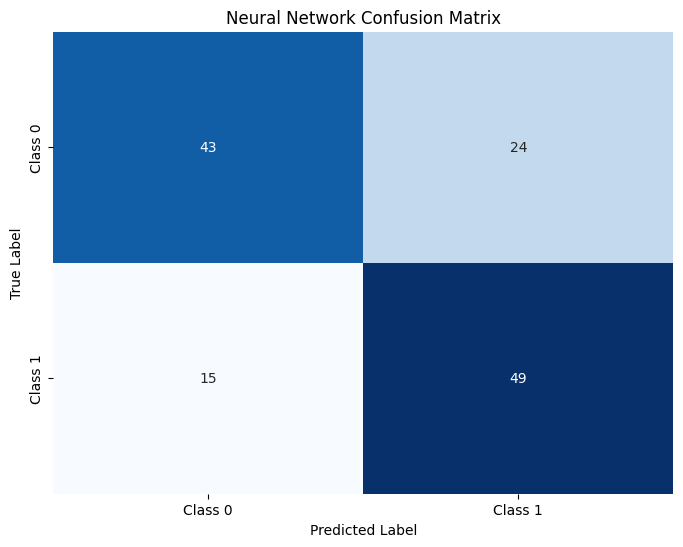

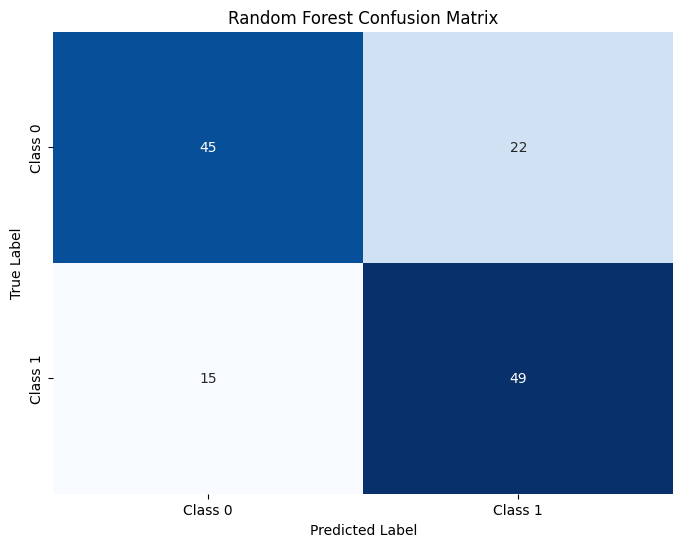

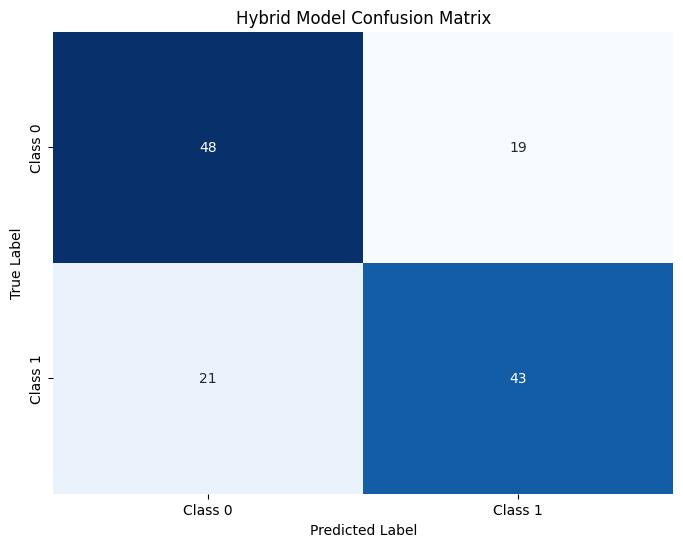

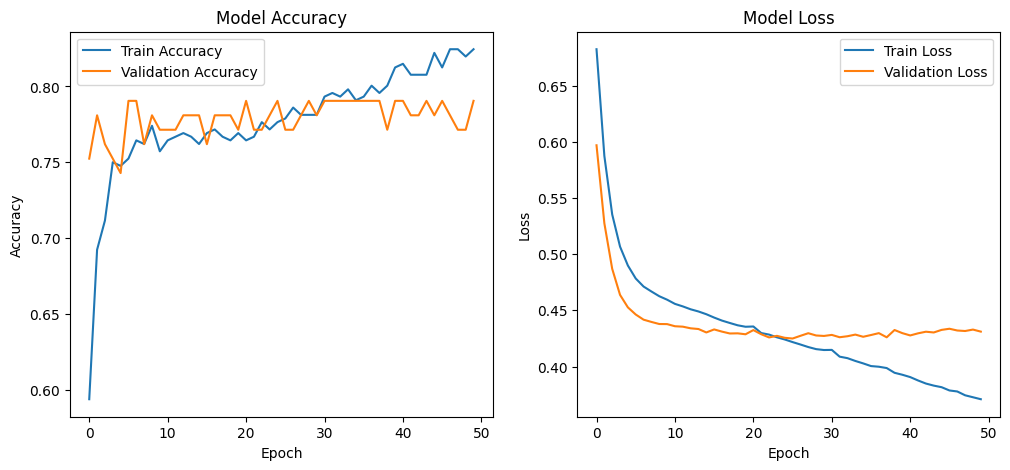

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import re
from tensorflow import keras
from tensorflow.keras import layers

# Load the dataset
dataframe = pd.read_csv('cleaned.csv')

# Exclude the unnecessary columns
columns_to_exclude = ['label', 'url', 'ssl_issuer', 'ssl_subject', 'ssl_not_before', 'ssl_not_after', 'domain','indexing_status']
X = dataframe.drop(columns=columns_to_exclude)
y = dataframe['indexing_status']

# Function to extract RGBA values (with default alpha = 0 if missing)
def extract_rgba(color):
    rgba_values = re.findall(r'\d+\.?\d*', color)  # This captures both integers and floats
    if len(rgba_values) == 3:  # If only RGB is present, default alpha (A) to 0
        rgba_values.append('0')
    return int(rgba_values[0]), int(rgba_values[1]), int(rgba_values[2]), float(rgba_values[3])

# Function to convert RGBA values to hex string (alpha scaled to [0, 255])
def rgba_to_hex(r, g, b, a):
    return f'{int(r):02x}{int(g):02x}{int(b):02x}{int(a * 255):02x}'  # Alpha scaled from [0, 1] to [0, 255]

# Apply the function to extract RGBA components and convert to hex
if 'background_color' in X.columns:
    X[['r', 'g', 'b', 'a']] = X['background_color'].apply(lambda x: pd.Series(extract_rgba(x)))
    # Convert rgba to hex
    X['color_hex'] = X.apply(lambda row: rgba_to_hex(row['r'], row['g'], row['b'], row['a']), axis=1)
    # Drop the individual r, g, b, a columns
    X = X.drop(columns=['r', 'g', 'b', 'a', 'background_color'])

# Convert non-numeric columns in X to numeric using label encoding (excluding rgba columns)
label_encoders = {}
for column in X.columns:
    if X[column].dtype == 'object' and column not in ['color_hex']:
        # Handle 'most_used_font_face' encoding while ignoring values wrapped in quotes
        if column == 'most_used_font_face':
            # Strip quotes from font face values and handle missing values
            X[column] = X[column].apply(lambda x: x.strip('"') if isinstance(x, str) else '')  # Check if it's a string first
        le = LabelEncoder()
        X[column] = le.fit_transform(X[column].astype(str))  # Encode the column
        label_encoders[column] = le

# Label encode the 'color_hex' column
if 'color_hex' in X.columns:
    le = LabelEncoder()
    X['color_hex_encoded'] = le.fit_transform(X['color_hex'].astype(str))
    X = X.drop(columns=['color_hex'])  # Drop the original hex color column after encoding

if 'indexing_status' in X.columns:
    le = LabelEncoder()
    X['indexing_status_encoded'] = le.fit_transform(X['indexing_status'].astype(str))
    X = X.drop(columns=['indexing_status']) 

# Convert target variable y to numeric using label encoding if necessary
if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y.astype(str))

# Keep the URL column for printing purposes, but exclude it from the analysis
X['url'] = dataframe['url']
X_for_analysis = X.drop(columns=['url'])  # Drop the URL column for analysis

# Step 2: Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_for_analysis, y, test_size=0.2, random_state=42)

# Step 3: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Define a Neural Network model
def create_nn_model(input_dim):
    model = keras.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(input_dim,)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Use 'softmax' for multi-class classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step 5: Train the Neural Network
nn_model = create_nn_model(X_train_scaled.shape[1])
history = nn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=1, validation_split=0.2)

# Step 6: Evaluate the Neural Network
nn_loss, nn_accuracy = nn_model.evaluate(X_test_scaled, y_test)
print(f"Neural Network Accuracy: {nn_accuracy:.4f}")

# Step 7: Predictions with Neural Network
nn_predictions = (nn_model.predict(X_test_scaled) > 0.5).astype("int32")

# Step 8: Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 9: Predictions with Random Forest
rf_predictions = rf_model.predict(X_test)

# Step 10: Combine predictions (Hybrid Model)
hybrid_predictions = np.round((nn_predictions.flatten() + rf_predictions) / 2)

# Step 11: Evaluate the models and display performance metrics
print("Classification report for Neural Network:")
print(classification_report(y_test, nn_predictions))

print("Classification report for Random Forest:")
print(classification_report(y_test, rf_predictions))

print("Classification report for Hybrid Model:")
print(classification_report(y_test, hybrid_predictions))

# Step 12: Confusion Matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(y_test, nn_predictions, "Neural Network Confusion Matrix")
plot_confusion_matrix(y_test, rf_predictions, "Random Forest Confusion Matrix")
plot_confusion_matrix(y_test, hybrid_predictions, "Hybrid Model Confusion Matrix")

# Step 13: Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()
